# T5 Model

In [ ]:
# Install required libraries
!pip install datasets transformers torch accelerate rouge-score -q

# Import libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import numpy as np
from rouge_score import rouge_scorer
import torch

print("GPU available:", torch.cuda.is_available())

# Load dataset
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset("cnn_dailymail", "3.0.0")
print(dataset)

# Data preprocessing
df = pd.DataFrame(dataset['train'])
df = df.drop_duplicates(subset='article')
df = df.dropna()

# Calculate lengths
df['article_len'] = df['article'].apply(lambda x: len(x.split()))
df['summary_len'] = df['highlights'].apply(lambda x: len(x.split()))

print("\nDataset Statistics:")
print(df[['article_len', 'summary_len']].describe())

# Visualize distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['article_len'], bins=50, color='blue', alpha=0.7)
plt.title("Article Length Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df['summary_len'], bins=50, color='orange', alpha=0.7)
plt.title("Summary Length Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Load T5-Small model and tokenizer
print("\nLoading T5-Small model...")
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Use smaller subset for faster training
print("\nPreparing training subset...")
train_subset = dataset['train'].select(range(5000))  # Use 5k samples
val_subset = dataset['validation'].select(range(500))  # Use 500 samples

# Preprocessing function for T5
def preprocess_data(examples):
    # T5 requires "summarize: " prefix
    inputs = ["summarize: " + article for article in examples['article']]

    model_inputs = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding='max_length'
    )

    # Tokenize targets
    labels = tokenizer(
        examples['highlights'],
        max_length=128,
        truncation=True,
        padding='max_length'
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Tokenize datasets
print("Tokenizing datasets...")
tokenized_train = train_subset.map(
    preprocess_data,
    batched=True,
    remove_columns=train_subset.column_names
)
tokenized_val = val_subset.map(
    preprocess_data,
    batched=True,
    remove_columns=val_subset.column_names
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-small-cnn-summarization",
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    learning_rate=3e-4,  # Higher LR for T5-small
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=1,  # Only 1 epoch for speed
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    report_to="none"
)

# Compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for pred, label in zip(decoded_preds, decoded_labels):
        scores = scorer.score(label, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores)
    }

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train model
print("\nStarting training...")
trainer.train()

# Save model
print("\nSaving model...")
trainer.save_model("./t5-small-final-model")
tokenizer.save_pretrained("./t5-small-final-model")

# Evaluate on test set
print("\nEvaluating on test set...")
test_subset = dataset['test'].select(range(500))
tokenized_test = test_subset.map(
    preprocess_data,
    batched=True,
    remove_columns=test_subset.column_names
)
test_results = trainer.evaluate(tokenized_test)
print("\nTest Results:")
print(test_results)
print(f"\n📊 ROUGE-1: {test_results['eval_rouge1']:.4f}")
print(f"📊 ROUGE-2: {test_results['eval_rouge2']:.4f}")
print(f"📊 ROUGE-L: {test_results['eval_rougeL']:.4f}")

# Generate sample summaries
print("\n" + "="*80)
print("SAMPLE SUMMARIES")
print("="*80)

test_articles = dataset['test'].select(range(3))

for i, example in enumerate(test_articles):
    print(f"\n--- Example {i+1} ---")
    print(f"\nOriginal Article (first 300 chars):\n{example['article'][:300]}...")

    # T5 requires "summarize: " prefix
    input_text = "summarize: " + example['article']
    inputs = tokenizer(input_text, max_length=512, truncation=True, return_tensors="pt")

    if torch.cuda.is_available():
        inputs = {k: v.to('cuda') for k, v in inputs.items()}

    summary_ids = model.generate(
        inputs['input_ids'],
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print(f"\nGenerated Summary:\n{generated_summary}")
    print(f"\nReference Summary:\n{example['highlights']}")
    print("-" * 80)

print("\n✅ Training complete! Model saved to './t5-small-final-model'")
print("\n📈 Final Accuracy Metrics (ROUGE scores) displayed above!")

## Model Save

In [ ]:
# Google Drive mount karo
from google.colab import drive
drive.mount('/content/drive')

# Model ko Drive mein copy karo
!cp -r ./t5-small-final-model/ /content/drive/MyDrive/

print("✓ Model saved to Google Drive!")
print("Location: MyDrive/t5-small-cnn-finetuned-final")

# Pegasus Model

GPU available: True
Loading CNN/DailyMail dataset...
DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

Dataset Statistics:
         article_len    summary_len
count  284005.000000  284005.000000
mean      692.232690      51.648802
std       336.645822      21.341967
min         8.000000       4.000000
25%       443.000000      38.000000
50%       632.000000      49.000000
75%       877.000000      60.000000
max      2347.000000    1296.000000


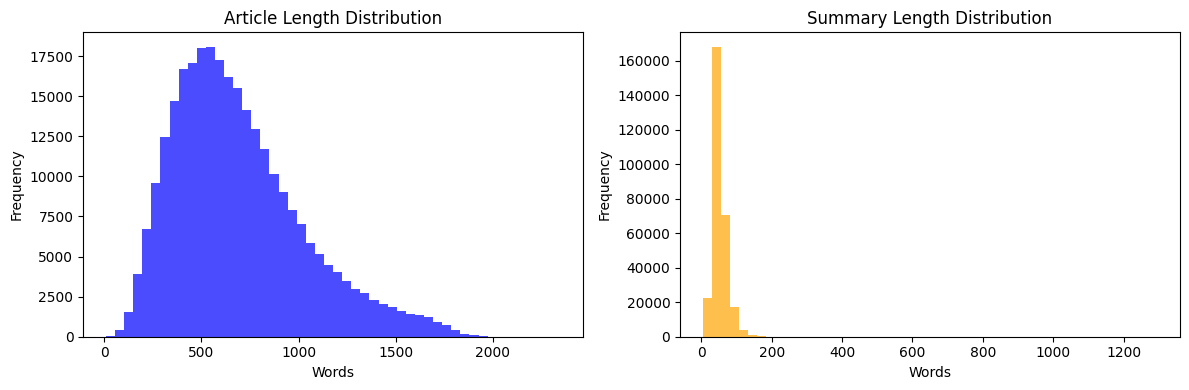


Loading Pegasus model...


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]


Preparing training subset...
Tokenizing datasets...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/tmp/ipython-input-1153267764.py:149: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.



Starting training...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
500,5.640900,6.339778,0.353699,0.156405,0.262721


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



Saving model...

Evaluating on test set...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]


Test Results:
{'eval_loss': 6.259195804595947, 'eval_rouge1': 0.3552010339130633, 'eval_rouge2': 0.15277448827520912, 'eval_rougeL': 0.25758651181367165, 'eval_runtime': 485.2776, 'eval_samples_per_second': 1.03, 'eval_steps_per_second': 0.258, 'epoch': 1.0}

SAMPLE SUMMARIES

--- Example 1 ---

Original Article (first 300 chars):
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the cou...

Generated Summary:
The Palestinian Authority formally becomes the 123rd member of the International Criminal Court . The move gives the court jurisdiction over alleged crimes in Palestinian territories . Israel and the United States opposed the Palestinians' efforts to join the body .

Reference Summary:
Membership gives the ICC jurisdiction over alleged crim

In [3]:
# Install required libraries
!pip install datasets transformers torch accelerate rouge-score -q

# Import libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import numpy as np
from rouge_score import rouge_scorer
import torch

print("GPU available:", torch.cuda.is_available())

# Load dataset
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset("cnn_dailymail", "3.0.0")
print(dataset)

# Data preprocessing
df = pd.DataFrame(dataset['train'])
df = df.drop_duplicates(subset='article')
df = df.dropna()

# Calculate lengths
df['article_len'] = df['article'].apply(lambda x: len(x.split()))
df['summary_len'] = df['highlights'].apply(lambda x: len(x.split()))

print("\nDataset Statistics:")
print(df[['article_len', 'summary_len']].describe())

# Visualize distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['article_len'], bins=50, color='blue', alpha=0.7)
plt.title("Article Length Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df['summary_len'], bins=50, color='orange', alpha=0.7)
plt.title("Summary Length Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Load Pegasus model and tokenizer
print("\nLoading Pegasus model...")
model_name = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Use smaller subset for faster training
print("\nPreparing training subset...")
train_subset = dataset['train'].select(range(5000))  # Use 5k samples
val_subset = dataset['validation'].select(range(500))  # Use 500 samples

# Preprocessing function
def preprocess_data(examples):
    inputs = tokenizer(
        examples['article'],
        max_length=512,
        truncation=True,
        padding='max_length'
    )
    outputs = tokenizer(
        examples['highlights'],
        max_length=128,
        truncation=True,
        padding='max_length'
    )
    inputs['labels'] = outputs['input_ids']
    return inputs

# Tokenize datasets
print("Tokenizing datasets...")
tokenized_train = train_subset.map(
    preprocess_data,
    batched=True,
    remove_columns=train_subset.column_names
)
tokenized_val = val_subset.map(
    preprocess_data,
    batched=True,
    remove_columns=val_subset.column_names
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./pegasus-cnn-summarization",
    eval_strategy="steps",  # Changed from evaluation_strategy
    eval_steps=500,
    save_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Increased for speed
    per_device_eval_batch_size=4,  # Increased for speed
    gradient_accumulation_steps=2,  # Reduced
    num_train_epochs=1,  # Only 1 epoch for speed
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    report_to="none"
)

# Compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for pred, label in zip(decoded_preds, decoded_labels):
        scores = scorer.score(label, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores)
    }

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train model
print("\nStarting training...")
trainer.train()

# Save model
print("\nSaving model...")
trainer.save_model("./pegasus-final-model")
tokenizer.save_pretrained("./pegasus-final-model")

# Evaluate on test set
print("\nEvaluating on test set...")
test_subset = dataset['test'].select(range(500))
tokenized_test = test_subset.map(
    preprocess_data,
    batched=True,
    remove_columns=test_subset.column_names
)
test_results = trainer.evaluate(tokenized_test)
print("\nTest Results:")
print(test_results)

# Generate sample summaries
print("\n" + "="*80)
print("SAMPLE SUMMARIES")
print("="*80)

test_articles = dataset['test'].select(range(3))

for i, example in enumerate(test_articles):
    print(f"\n--- Example {i+1} ---")
    print(f"\nOriginal Article (first 300 chars):\n{example['article'][:300]}...")

    inputs = tokenizer(example['article'], max_length=512, truncation=True, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = {k: v.to('cuda') for k, v in inputs.items()}

    summary_ids = model.generate(
        inputs['input_ids'],
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print(f"\nGenerated Summary:\n{generated_summary}")
    print(f"\nReference Summary:\n{example['highlights']}")
    print("-" * 80)

print("\n✅ Training complete! Model saved to './pegasus-final-model'")

In [5]:
# Google Drive mount karo
from google.colab import drive
drive.mount('/content/drive')

# Model ko Drive mein copy karo
!cp -r ./pegasus-final-model/ /content/drive/MyDrive/

print("✓ Model saved to Google Drive!")
print("Location: MyDrive/pegasus-final-model")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Model saved to Google Drive!
Location: MyDrive/pegasus-final-model


# Conclusion

Based on the given results, the Pegasus model performs better for the text summarization task. Even though its training and validation loss values are higher, its evaluation metrics (ROUGE-1, ROUGE-2, and ROUGE-L) are significantly better than those of T5-small. ROUGE scores directly reflect the quality and relevance of the generated summaries, showing how closely the model's output matches the reference summary. Since Pegasus is specifically designed for abstractive summarization and has pretraining objectives tailored for summarizing long text, it is naturally more effective in generating coherent and informative summaries compared to T5-small, which is a more general-purpose language model.